In [69]:
import json
import os
import pandas as pd
import numpy as np


# Introduction
The dataset was downloaded from https://www.kaggle.com/datasets/rmisra/news-category-dataset/data.

The data is available as a .json file (News_Category_Dataset_v3.json), which can be read directly into a pandas dataframe with 209527 rows.

In [210]:
# If using Google Colab, upload .json file into root content directory (as per path below) during working session.
# If using a local Jupyter Notebook, edit the paths below to point to your working folder.
# root = '/content' # For Google Colab
root = "/Users/cathytay/60-69-Code/61.06-TextClassification/data"
df = pd.read_json(os.path.join(root, "News_Category_Dataset_v3.json"), lines = True)

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [39]:
df.head(2) # view data samples

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9,Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters,U.S. NEWS,Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlines-passenger-banned-flight-attendant-punch-justice-department_n_632e25d3e4b0e247890329fe,"American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video",U.S. NEWS,"He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.",Mary Papenfuss,2022-09-23


In [40]:
df.tail(2)

,link,headline,category,short_description,authors,date
209525,https://www.huffingtonpost.com/entry/aldon-smith-arrested-dui-49ers_us_5bb69b25e4b097869fd1b33c,Aldon Smith Arrested: 49ers Linebacker Busted For DUI,SPORTS,CORRECTION: An earlier version of this story incorrectly stated the location of KTVU and the 2011 league leader in sacks,,2012-01-28
209526,https://www.huffingtonpost.com/entry/dwight-howard-rips-teammates-magic-hornets_us_5bb69b24e4b097869fd1b331,Dwight Howard Rips Teammates After Magic Loss To Hornets,SPORTS,The five-time all-star center tore into his teammates Friday night after Orlando committed 23 turnovers en route to losing,,2012-01-28


# Dataset composition

In [41]:
# Check value counts of categories and percentage composition of dataset
print(f"Number of categories: {df['category'].nunique()}\n")

df_count = df.category.value_counts().rename_axis('category').reset_index(name='count')
df_count['percent'] = ((df_count['count']/df_count['count'].sum())*100).round(2)
df_count

Number of categories: 42



,category,count,percent
0,POLITICS,35602,16.99
1,WELLNESS,17945,8.56
2,ENTERTAINMENT,17362,8.29
3,TRAVEL,9900,4.72
4,STYLE & BEAUTY,9814,4.68
5,PARENTING,8791,4.20
6,HEALTHY LIVING,6694,3.19
7,QUEER VOICES,6347,3.03
8,FOOD & DRINK,6340,3.03
9,BUSINESS,5992,2.86


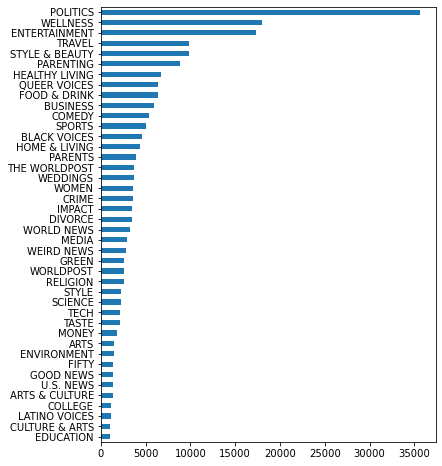

In [42]:
df['category'].value_counts().sort_values().plot(kind='barh', figsize=(6,8)); # adjust height figsize else y labels too close

This is an extremely imbalanced dataset with 42 news categories.

There are 3 major categories that account for more than 33% of the dataset:
- Politics (17.0%)
- Wellness (8.6%)
- Entertainment (8.3%)

The remaining 66% of the data consists of 39 minor categories.

The minority categories have about 1000 - more than 9000 learning examples each.

The possible ways to proceed with training a classifier model are:

(1) dropping categories using various category size thresholds (e.g. <5000) to focus on the larger or more common categories. (KIV: As the smallest category has more than 1000 samples, is it feasible to keep the categories and undersample the large categories?)

(2) undersampling the largest classes (Politics, Wellness, Entertainment)

(3) oversampling minority classes

(4) consolidating some or all minority classes into fewer classes (if dropping them altogether is undesirable e.g. rounded coverage of news data is required)

In [212]:
# Sample some of the categories for a feel of the data
pd.set_option('display.max_colwidth', None)

df_read = df[['category', 'headline', 'short_description']]
p = df_read.loc[
    (df_read['category']=='U.S. NEWS') |
    (df_read['category']=='WORLD NEWS') ] #  BUSINESS TECH POLITICS U.S. NEWS
p.sample(20)



,category,headline,short_description
1178,U.S. NEWS,Biden: NFL Should Exercise ‘Generic Decency’ When It Comes To Hiring,Biden's interview with Lester Holt aired during NBC’s Super Bowl LVI Pregame Show.
8504,WORLD NEWS,North Korea Kidnapped Her 13-Year-Old Daughter. She Spent Decades Trying To Get Her Back.,"During the 1970s and 80s, North Korea abducted at least 17 Japanese citizens."
715,WORLD NEWS,Beijing Loyalist John Lee Elected As Hong Kong's Next Leader,The election followed major changes to Hong Kong’s electoral laws last year to ensure that only “patriots” loyal to Beijing can hold office.
6939,U.S. NEWS,Black Hole Scientist Defends Female Colleague Against Sexist Trolls,"Andrew Chael blasted sexist social media attacks on Katie Bouman, who helped develop an algorithm used to capture this week's historic black hole photo."
34325,WORLD NEWS,U.S. Warship Sails Within 12 Miles Of China-Claimed Reef,This is the first such challenge to Beijing under President Trump.
12144,WORLD NEWS,Picture This: Shaggy Is Performing At The Queen's Birthday Concert,"Imagine her face during ""It Wasn't Me."""
6418,U.S. NEWS,Kim Kardashian Visits D.C. Jail To Discuss Criminal Justice Reform,The reality star also spoke about a higher education initiative at the facility and filmed footage for a documentary on her criminal justice activism.
6889,U.S. NEWS,"Tinder Bans George Zimmerman From Dating App, Citing User Safety",A spokesperson confirmed that the app removed the man known for killing unarmed teenager Trayvon Martin.
20002,WORLD NEWS,2.5 Million Yemenis Lack Access To Clean Water: Red Cross,"A Saudi-led coalition is cutting off supplies to vulnerable Yemenis, the Red Cross said Monday."
2555,U.S. NEWS,2 Passengers Test Positive For COVID-19 On First North American Cruise In 15 Months,"The Celebrity Millenium guests ""are asymptomatic and currently in isolation"" after testing positive before the ship's return to St. Maarten."


There is some overlap in news content among categories, e.g. some business articles may be about technology companies and vice versa.

It might be a worthwhile to consolidate such overlapping categories into a single category to prevent inconsistent learning and 'confused' models, especially where the objective of the model is to classify only to a single label or category.

# Headline and description lengths

In [213]:
# Function to estimate text sequence length
def string_length(s, sep=None):
  split_ls = s.split(sep)
  return len(split_ls)

In [214]:
df.loc[:, 'length_headline'] = df['headline'].apply(string_length)
df.loc[:,'length_desc'] = df['short_description'].apply(string_length)
df.head(2)

,link,headline,category,short_description,authors,date,length_headline,length_desc
0,https://www.huffpost.com/entry/covid-boosters-uptake-us_n_632d719ee4b087fae6feaac9,Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters,U.S. NEWS,Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.,"Carla K. Johnson, AP",2022-09-23,11,29
1,https://www.huffpost.com/entry/american-airlines-passenger-banned-flight-attendant-punch-justice-department_n_632e25d3e4b0e247890329fe,"American Airlines Flyer Charged, Banned For Life After Punching Flight Attendant On Video",U.S. NEWS,"He was subdued by passengers and crew when he fled to the back of the aircraft after the confrontation, according to the U.S. attorney's office in Los Angeles.",Mary Papenfuss,2022-09-23,13,28


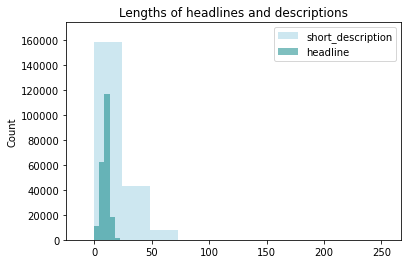

In [77]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(df['length_desc'], color='lightblue', alpha=0.6, label='short_description')
ax.hist(df['length_headline'], color='teal', alpha=0.5, label='headline')
ax.legend()
ax.set(title='Lengths of headlines and descriptions', ylabel='Count')
ax.margins(0.1)
# ax.set_ylim(bottom=0)

plt.show()

Most of the headline entries and descriptions are 10 - 20 words in length (inclusive of any numbers). They are quite clean text i.e. not necessary to clean further.

In [215]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
 6   length_headline    209527 non-null  int64         
 7   length_desc        209527 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 12.8+ MB


In [255]:
# Drop link column as it is not informative
df.drop(columns = ['link'], inplace=True)

In [80]:
# Save EDA dataset
df.to_csv(os.path.join(root,"data_EDA.csv"), index=False)

# Data pre-filter: minimum number of entries

In [216]:
# Function to keep the categories with a minimum number (n) of entries
cat_counts = df['category'].value_counts()

def cat_dropper(df, n):
  '''
  Takes in a dataframe, and a minimum number (n) of entries required for categories
  Drops rows belonging to categories that have less than n entries in the dataframe
  Returns dataframe with categories that have n or more entries

  '''
  df1 = df.loc[df['category'].isin(cat_counts[cat_counts >= n].index)]
  print(f"Number of rows dropped = {len(df)- len(df1)}")
  return df1

In [256]:
df1 = cat_dropper(df, 5000) # Drop categories with <5000 entries
df1.head(2)

Number of rows dropped = 74263


,headline,category,short_description,authors,date,length_headline,length_desc
2,23 Of The Funniest Tweets About Cats And Dogs This Week (Sept. 17-23),COMEDY,"""Until you have a dog you don't understand what could be eaten.""",Elyse Wanshel,2022-09-23,13,12
3,The Funniest Tweets From Parents This Week (Sept. 17-23),PARENTING,"""Accidentally put grown-up toothpaste on my toddler’s toothbrush and he screamed like I was cleaning his teeth with a Carolina Reaper dipped in Tabasco sauce.""",Caroline Bologna,2022-09-23,9,25


In [257]:
df1.category.nunique()

12

In [246]:
df1.category.value_counts()

POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
Name: category, dtype: int64

At this point of experimentation, we decide to drop minor categories with less than 5000 records. There is still imbalance in the dataset, albeit less pronounced. We can explore sampling techniques (e.g. random oversampling) to deal with this.


As the headlines are rather short, we will concatenate them with the short descriptions, to enrich the information present for each article. 

In [258]:
df1[['headline', 'short_description','category', ]].sample(10)

,headline,short_description,category
191694,Megan Rossee: Michael Phelps' Girlfriend Is An Aspiring Model (PHOTOS),"So, until Megan decides to give her inevitable slew of interviews, this is what we know about Ms. Rossee other than the fact",STYLE & BEAUTY
86271,Confederate Flag Supporters Indicted Under Georgia's Anti-Gang Law,The decision affects more than a dozen members of a group called Respect The Flag.,POLITICS
24456,How Facebook's 'Authentic Name' Policy Serves To Create A Hostile Environment For Transgender Stalking Victims,I am far from the only victim.,QUEER VOICES
83525,Nick Jonas Remembers His Teen Love For Miley Cyrus In Perfect Throwback,They're honestly a Romeo and Juliet of our time.,ENTERTAINMENT
38575,Church Leaders Are Begging Their State's Senator To Give Up Global Warming Denial,“We see no conflict between our religious faith and the findings of science.”,POLITICS
85212,Timberwolves Head Coach Phil 'Flip' Saunders Dies Of Cancer,"MINNEAPOLIS (AP) — Flip Saunders, the longtime NBA coach who won more than 650 games in nearly two decades and was trying",SPORTS
136690,How Our Words And Emotions Affect Our Communication,Rossellini also explains how the feelings connected to our speech are what's really indicative of our expression. The perfect,WELLNESS
33445,Supreme Court To Review Whether Cops Need A Warrant To Obtain Your Phone's Location,The issue has long perplexed lower courts and alarmed privacy advocates.,POLITICS
55138,Donald Trump Doesn't Seem To Have A Clue How To Appeal To Millennials,"Hillary Clinton's campaign, by contrast, is really trying.",POLITICS
104962,Gay Man Recounts Coming Out to His Devout Muslim Father (VIDEO),,QUEER VOICES


## Treatment of text with emoticons

In [260]:
# some emoticons present in short descriptions
df1.loc[147826]['short_description']

'Holiday dress season at Anthro, bye paychecks ✈️✨💰 — Taylor Lorenz (@TaylorLorenz) November 13, 2013 Life is incredible'

In [263]:
# text with emoticons
df1.loc[22912]['short_description']

'👻  😂'

In [261]:
# text with apostrophe's (check if they are retained after encode/decode)
df1.loc[26970]['short_description']

"Ever-more specialized American surgeons don't learn the skills needed in areas stricken by war, earthquakes or other disasters."

- There are some non-text items like emojis in the short description e.g. at index 22912, 147826

In [271]:
# Attempt to remove emoticons/emoji's
df_test = df1.copy()

for col in df_test[['headline', 'short_description']]:
    df_test[col] = df_test[col].apply(lambda x: x.encode('unicode-escape').decode('utf-8')) #'ASCII'

#decode ASCII / utf-8: \u2708\ufe0f\u2728\U0001f4b0 \u2014 

df_test.loc[147826] #26970 #22912 147826


headline                                                                             Victoria's Secret Models Try To Sneak In Flats At The Show & More Tweets Of The Week
category                                                                                                                                                   STYLE & BEAUTY
short_description    Holiday dress season at Anthro, bye paychecks \u2708\ufe0f\u2728\U0001f4b0 \u2014 Taylor Lorenz (@TaylorLorenz) November 13, 2013 Life is incredible
authors                                                                                                                                                                  
date                                                                                                                                                  2013-11-16 00:00:00
length_headline                                                                                                                                       

In [274]:
emo = df_test.loc[df_test['short_description'].str.contains(r'\\U00\S+', regex=True)]
emo # 403 rows with emoji's

,headline,category,short_description,authors,date,length_headline,length_desc
1958,Nicole Richie Accidentally Sets Her Hair On Fire While Blowing Out Birthday Candles,ENTERTAINMENT,"\u201cWell, so far 40 is \U0001f525,\u201d the reality star turned actor and fashion designer captioned video of the scary incident.",Lee Moran,2021-09-22,13,20
5538,There's A Lot Of Leopard Print On Sale At The Nordstrom Half-Yearly Sale,STYLE & BEAUTY,"Animal prints aren't going away anytime soon and\xa0luckily, the Nordstrom Half-Yearly Sale is filled with leopard print shoes, sweaters and coats \U0001f406",Ambar Pardilla,2019-12-28,13,23
7225,Nordstrom's Winter Sale Has A Lot Of Cheap Mules And Slides For Spring,STYLE & BEAUTY,Shoe deals you won't want to walk away from \U0001f461,Brittany Nims,2019-02-20,13,10
7419,Alexandria Ocasio-Cortez Channels Spice Girls In Government Shutdown Tweets,POLITICS,"\U0001f3b6 Now don't go wasting our precious time, if they get their act together we could be just fine \U0001f3b6",Lee Moran,2019-01-18,9,20
7998,What Is Kanye West's iPhone Password?,POLITICS,\U0001f631\U0001f631\U0001f631\U0001f631\U0001f631\U0001f631,Andy Campbell,2018-10-11,6,1
...,...,...,...,...,...,...,...
88565,Jessica Simpson's HSN Appearance Has Some Scratching Their Heads,ENTERTAINMENT,\U0001f646,Cavan Sieczkowski,2015-09-18,9,1
88815,Amber Rose Rocks A Long Brown Wig For Night On The Town,ENTERTAINMENT,\U0001f525\U0001f525\U0001f525,Stephanie Marcus,2015-09-15,12,1
89121,New England Patriots Open NFL Season By Defeating Pittsburgh Steelers 28-21,SPORTS,Football is back \U0001f64f\U0001f3c8,Justin Block,2015-09-11,11,4
146639,Walmart's Black Friday Going About As Badly As You'd Expect,BUSINESS,"Seen the first fight of the night \U0001f602 only at Walmart \u2014 Sammantha (@Samm_Nani) November 29, 2013 Lol there was a fight at",,2013-11-29,10,23


In [294]:
emo.category.value_counts()

ENTERTAINMENT     159
POLITICS           72
QUEER VOICES       54
TRAVEL             37
COMEDY             29
HEALTHY LIVING     21
SPORTS             20
BUSINESS            8
STYLE & BEAUTY      3
Name: category, dtype: int64

In [276]:
# text with apostrophe's or quotes that are converted 
quo = df_test.loc[df_test['short_description'].str.contains(r'\\u\S+', regex=True)]
len(quo)

10833

A side effect of trying to decode/encodes the emoticons is that the apostrophes and quote marks are also converted. There are 10.8K rows with quote marks altered into another format. At this point, the correct method to rectify this side effect is unclear.

As there are only 403 rows with emojis/emoticons, it is easier at this point to just drop these 403 rows from the original dataframe, and carry on with the original unchanged format, so as to preserve the integrity of the quote marks. These quote marks may be later removed during punctuation removal stage of text processing. If they are converted for example into "\u2019" or similar strings, this might affect proper text processing. 

Based on the value counts above, the number of dropped data rows are an insignificant fraction of the news categories.

In [286]:
# Drop 403 rows with emoji's
df2 = df1[~df1.index.isin(emo.index)]
len(df2)

134861

## Join headline with short description

- Some short_description are blank, but for most rows, the short description provides more information or context on the headline. Thus it would be helpful to join headline with description for richer text input. 

In [289]:
# Concatenate headline and short description into 'text' column
df2.loc[:,'text'] = df2['headline'] + ' ' + df2['short_description']

/opt/anaconda3/envs/repo/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/opt/anaconda3/envs/repo/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [292]:
df2.sample()

,headline,category,short_description,authors,date,length_headline,length_desc,text
169951,Easter Candy Bark,FOOD & DRINK,"If you're making Easter Candy Bark, you have a very legitimate excuse to stock up on all sorts of pastel egg-shaped morsels. And when you're done, you'll have each type of candy left over.","Jessie Roberts, Contributor\nJessie Next Door",2013-03-28,3,34,"Easter Candy Bark If you're making Easter Candy Bark, you have a very legitimate excuse to stock up on all sorts of pastel egg-shaped morsels. And when you're done, you'll have each type of candy left over."


In [293]:
# Export selected columns of processed dataset
df2 = df2[['headline', 'category', 'short_description', 'text', 'date', 'length_headline', 'length_desc']]
df2.to_csv(os.path.join(root, "data_processed_12cats.csv"), index=False)